## Install libraries

In [ ]:
import pandas as pd
import numpy as np

# models
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

# pre-processing
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN

# data engineering 
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from matplotlib.pyplot import figure

In [ ]:
# Connnect to google drive 
from google.colab import drive
drive.mount('/content/gdrive')

# Load dataset
df = pd.read_csv('/content/gdrive/MyDrive/Cybersecurity Exam/Dataset/phishing.csv')


Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Exploratory Data Analysis

In [ ]:
#Finding the most occuring characters
subset_df = df.copy()
#Splitting into phishing and legit
phishing_df = subset_df[subset_df['phishing']==1]
legit_df = subset_df[subset_df['phishing']==0]
def get_occuring_features(df):
  filtered_cols = [col for col in df if col.startswith('qty')] # take only features with quantity in name
  sub_df = df[filtered_cols] # subset right columns
  sub_df = sub_df[subset_df[subset_df.columns.values]>0] # subset non negative values
  sub_df = sub_df.drop(['qty_nameservers', 'qty_mx_servers'], axis=1) # remove non character columns

  s = sub_df.sum(axis=0).sort_values(ascending=False) # sum up to see quantity
  top_n_features = sub_df[s.index[:5]]
  df_qty_visualisation = pd.DataFrame()
  df_qty_visualisation['Sum'] = top_n_features.sum(axis=0)
  df_qty_visualisation = df_qty_visualisation.reset_index()
  df_qty_visualisation = df_qty_visualisation.sort_values(by=['Sum'],ascending=False)
  return df_qty_visualisation

df_vis_phishing = get_occuring_features(phishing_df)
df_vis_legit = get_occuring_features(legit_df)
df["phishing"].value_counts() # 35% is phishing

0    58000
1    30647
Name: phishing, dtype: int64

<Figure size 2700x1800 with 0 Axes>

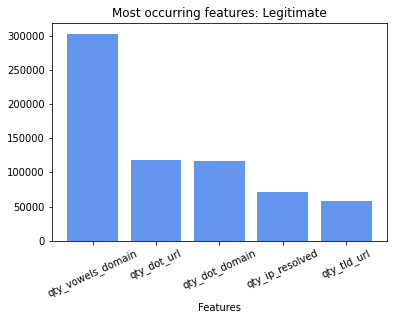

<Figure size 2700x1800 with 0 Axes>

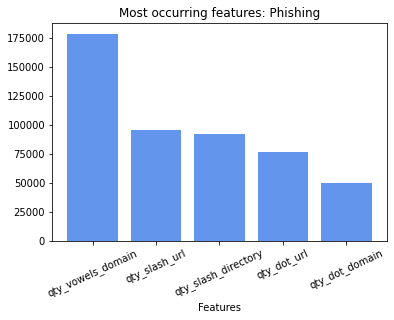

In [ ]:
def CharCountVisualization(df_features_qty, name):
  ''' Create a visalisation with top 5 informative features. 
  As input takes dataframe with 2 columns : index - names of features, Sum - frequency of occurrence'''
  figure(figsize=(9, 6), dpi=300)
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.bar(df_features_qty['index'], df_features_qty['Sum'], color='cornflowerblue', align='center')
  plt.xticks(rotation=25)
  plt.xlabel('Features')
  plt.title('Most occurring features: ' + name)
  return plt.show()
CharCountVisualization(df_vis_legit, "Legitimate")
CharCountVisualization(df_vis_phishing, "Phishing")

In [ ]:
# Checking the summary statistics
df.describe()

# Dropping unnecessary columns
df = df.drop('Unnamed: 0', axis=1)

# Find the columns with the highest and lowest values
pd.set_option('display.max_rows', None)
df.max().sort_values(ascending=False)
df.min().sort_values(ascending=False)

length_url                    4.0
domain_length                 4.0
qty_dot_url                   1.0
qty_dollar_domain             0.0
qty_and_domain                0.0
qty_exclamation_domain        0.0
qty_space_domain              0.0
qty_tilde_domain              0.0
qty_comma_domain              0.0
qty_plus_domain               0.0
qty_asterisk_domain           0.0
qty_hashtag_domain            0.0
qty_percent_domain            0.0
qty_equal_domain              0.0
qty_vowels_domain             0.0
domain_in_ip                  0.0
server_client_domain          0.0
qty_hyphen_url                0.0
email_in_url                  0.0
qty_nameservers               0.0
qty_mx_servers                0.0
tls_ssl_certificate           0.0
url_shortened                 0.0
qty_at_domain                 0.0
phishing                      0.0
qty_questionmark_domain       0.0
qty_comma_url                 0.0
qty_at_url                    0.0
qty_equal_url                 0.0
qty_questionma

## Pre-processing of data

In [ ]:
# split data
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df["phishing"], test_size=0.3, random_state=42)

# re-sample data
ada = ADASYN(random_state=42)
x_train_adasyn, y_train_adasyn = ada.fit_resample(x_train, y_train)

## Building models

In [ ]:
def PhishingClassifier(x, y, est, analysis, params):
    """ A function returns the best model using Randomized Search. Input: x - test set; y - labels; est - classifier to apply. 
    One of 4 classifiers can be specified 'rfc' - Random Forest; 'svc' - Suport Vectore Classifier; 'xgb' - XGBoost; 'nb' - Naive Bayes;
    analysis - data engineering technique to be used. Dimentionality reduction - pca; 
    feature selection - Regression Weight Approach (sfm) or recursive feature elemenation (rfe); """
    
    # dictionary with data engineering techniques
    dim = {'pca' : PCA(n_components = 0.95), 'sfm' : SelectFromModel(estimator = LogisticRegression(max_iter = 1000)),
          'rfe' : RFE(LogisticRegression(max_iter = 1000), step=10)}
    # dictionary with classifiers
    clf = {'rfc': RandomForestClassifier(), 'svc': SVC(max_iter=1000), 'xgb': XGBClassifier(), 'nb': GaussianNB()}
    
    # pipeline to apply to data. First scales features, then reduces number of features, finally applies classifier
    pipe = Pipeline([("scaler", MinMaxScaler()),
        ("feature", dim[analysis]),
        ("classifier", clf[est])])

    #trains a model, selects parameters using randomized search
    model = RandomizedSearchCV(estimator=pipe, param_distributions=params, cv=5, scoring="f1", refit=True, n_iter = 7)
    model.fit(x, y)
    
    #prints scores and model estimators
    print("best mean cross-validation score: {:.3f}".format(model.best_score_))
    print("best parameters:", model.best_params_) 
  
    series = pd.Series([est, model.best_score_, analysis],index = ["model", "mean_score", "Dim_reduction"]) #Extracting model name, mean_score and selected features
    return model, series

In [ ]:
def get_params(clf, dim):
  """ Function returns a dictionary of parameters to be optimized using randomized search. As input classifier and data engineering technique 
  should be specified """
  global params
  # specifies the classifier
  if clf=="rfc":
    # specifies the data engineering technique
    if dim=="rfe":
      params = {"classifier__bootstrap" : [True, False], 
              'classifier__max_features' : ['auto', 'sqrt', 'log2'],
              'classifier__max_depth' :  list(range(1, 10)),
              'classifier__criterion' : ['gini', 'entropy'],
              'classifier__n_estimators' :  list(range(1, 200)),
              'feature__n_features_to_select' : list(range(1, 60))}

    elif dim=="pca":
      params = {"classifier__bootstrap" : [True, False], 
              'classifier__max_features' : ['auto', 'sqrt', 'log2'],
              'classifier__max_depth' :  list(range(1, 10)),
              'classifier__criterion' : ['gini', 'entropy'],
              'classifier__n_estimators' :  list(range(1, 200)),
              'feature__whiten' : [True, False],
              'feature__svd_solver' : ['auto', 'full']}
    
    elif dim=="sfm":
      params = {"classifier__bootstrap" : [True, False], 
              'classifier__max_features' : ['auto', 'sqrt', 'log2'],
              'classifier__max_depth' :  list(range(1, 10)),
              'classifier__criterion' : ['gini', 'entropy'],
              'classifier__n_estimators' :  list(range(1, 200)),
              'feature__max_features' : list(range(1, 60))}

  if clf=="xgb":
    if dim=="rfe":
      params = {'classifier__max_depth': [3, 18, 1],
                    'classifier__gamma': [1,9],
                    'classifier__reg_alpha':[40,180,1],
                    'classifier__reg_lambda': [0,1],
                    'classifier__colsample_bytree': [0.5,1],
                    'classifier__min_child_weight': [0,10,1],
                    'classifier__n_estimators': [180],
                    'feature__n_features_to_select' : list(range(1, 60))}
    elif dim=="pca":
      params = {'classifier__max_depth': [3, 18, 1],
                    'classifier__gamma': [1,9],
                    'classifier__reg_alpha':[40,180,1],
                    'classifier__reg_lambda': [0,1],
                    'classifier__colsample_bytree': [0.5,1],
                    'classifier__min_child_weight': [0,10,1],
                    'classifier__n_estimators': [180],
                    'feature__whiten' : [True, False],
                    'feature__svd_solver' : ['auto', 'full']}
    
    elif dim=="sfm":
      params = {'classifier__max_depth': [3, 18, 1],
                    'classifier__gamma': [1,9],
                    'classifier__reg_alpha':[40,180,1],
                    'classifier__reg_lambda': [0,1],
                    'classifier__colsample_bytree': [0.5,1],
                    'classifier__min_child_weight': [0,10,1],
                    'classifier__n_estimators': [180],
                    'feature__max_features' : list(range(1, 60))}
  elif clf=="svc":
    if dim=="rfe":
      params = {"classifier__C" : [0.1,1, 10, 100, 1000],
              'classifier__gamma': [1,0.1,0.01, 0.001, 0.0001],
              'classifier__kernel': ['rbf', 'linear'],
              'feature__n_features_to_select' : list(range(1, 60))}

    elif dim=="pca":
      params = {"classifier__C" : [0.1,1, 10, 100, 1000],
              'classifier__gamma': [1,0.1,0.01, 0.001, 0.0001],
              'classifier__kernel': ['linear'],
              'feature__whiten' : [True, False],
              'feature__svd_solver' : ['auto', 'full']}
    
    elif dim=="sfm":
      params = {"classifier__C" : [0.1,1, 10, 100, 1000],
              'classifier__gamma': [1,0.1,0.01, 0.001, 0.0001],
              'classifier__kernel': ['linear'],
              'feature__max_features' : list(range(1, 60))}
  
  elif clf=="nb":
    if dim=="rfe":
      params = {'feature__n_features_to_select' : list(range(1, 60))}
    elif dim=="pca":
      params = {'feature__whiten' : [True, False],
                'feature__svd_solver' : ['auto', 'full']}
    
    elif dim=="sfm":
      params = {'feature__max_features' : list(range(1, 60))}

  return params

In [ ]:
def get_accuracy(x_test,y_test,model, key, show_conf_matrix=False):
  """ A customized function to display accuracy and confusion matrix. To get output test data set, labels, key (classifier_feature engineering), and model should be specified,
   To show confusion matrix, True should be specified, otherwise false (default status is false). """
  # predict whether a website is phishing
  y_pred = model.predict(x_test)
  # check accuracy
  accuracy = accuracy_score(y_test,y_pred)
  if show_conf_matrix == True:
    #Creating the confusion matrix
    confus_matrix = confusion_matrix(y_test, y_pred)
    confus_matrix = np.round(confus_matrix / confus_matrix.sum(axis=1, keepdims=True),2)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(confus_matrix, annot=True, cmap="YlGnBu", 
                xticklabels=["legitimate", "phishing"], 
                yticklabels=["legitimate", "phishing"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("CONFUSION MATRIX\n" + key, size=18)
  return accuracy

In [ ]:
# Creating table to hold results
columns = ["model", "mean_score", "Dim_reduction"]
df_results = pd.DataFrame(columns=columns)

In [ ]:
def train_and_store_result(clf, dim, df):
    """ A Function to train models and store results of best models in a dataframe. Input: classifier, data engineering technique, and dataframe to store data"""
    
    model, series = PhishingClassifier(x_train_adasyn,y_train_adasyn,clf,dim,get_params(clf,dim))
    df_results = df.append(series,ignore_index=True)
    return model, df_results

models = ['rfc','svc','xgb', 'nb']
dim_features = ['rfe', 'pca','sfm']

In [ ]:
#Running each model and storing them in dictionary
model_dict = {}
for specified_model in models:
  print(specified_model)
  for dimension in dim_features:
    print(dimension)
    new_model, df_results = train_and_store_result(specified_model,dimension,df_results)
    model_dict[specified_model + "_" + dimension] = new_model

rfc
rfe
best mean cross-validation score: 0.942
best parameters: {'feature__n_features_to_select': 37, 'classifier__n_estimators': 92, 'classifier__max_features': 'log2', 'classifier__max_depth': 7, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
pca
best mean cross-validation score: 0.930
best parameters: {'feature__whiten': False, 'feature__svd_solver': 'auto', 'classifier__n_estimators': 157, 'classifier__max_features': 'auto', 'classifier__max_depth': 8, 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}
sfm
best mean cross-validation score: 0.949
best parameters: {'feature__max_features': 13, 'classifier__n_estimators': 72, 'classifier__max_features': 'auto', 'classifier__max_depth': 8, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
svc
rfe


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1

best mean cross-validation score: 0.837
best parameters: {'feature__n_features_to_select': 40, 'classifier__kernel': 'linear', 'classifier__gamma': 0.01, 'classifier__C': 100}
pca


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1

best mean cross-validation score: 0.841
best parameters: {'feature__whiten': False, 'feature__svd_solver': 'auto', 'classifier__kernel': 'linear', 'classifier__gamma': 0.0001, 'classifier__C': 100}
sfm


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1

best mean cross-validation score: 0.798
best parameters: {'feature__max_features': 44, 'classifier__kernel': 'linear', 'classifier__gamma': 0.001, 'classifier__C': 100}
xgb
rfe
best mean cross-validation score: 0.963
best parameters: {'feature__n_features_to_select': 53, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 40, 'classifier__n_estimators': 180, 'classifier__min_child_weight': 10, 'classifier__max_depth': 18, 'classifier__gamma': 1, 'classifier__colsample_bytree': 0.5}
pca
best mean cross-validation score: 0.929
best parameters: {'feature__whiten': True, 'feature__svd_solver': 'full', 'classifier__reg_lambda': 0, 'classifier__reg_alpha': 40, 'classifier__n_estimators': 180, 'classifier__min_child_weight': 10, 'classifier__max_depth': 18, 'classifier__gamma': 9, 'classifier__colsample_bytree': 0.5}
sfm
best mean cross-validation score: 0.957
best parameters: {'feature__max_features': 24, 'classifier__reg_lambda': 0, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=7. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


best mean cross-validation score: 0.907
best parameters: {'feature__whiten': True, 'feature__svd_solver': 'auto'}
sfm
best mean cross-validation score: 0.891
best parameters: {'feature__max_features': 30}


## Results

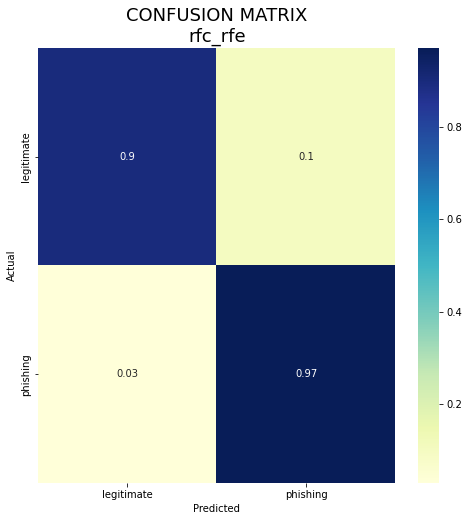

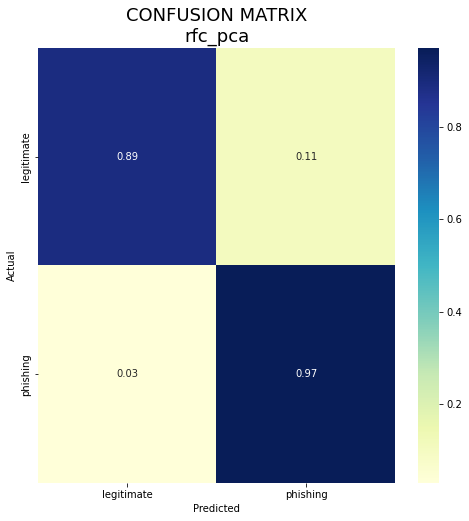

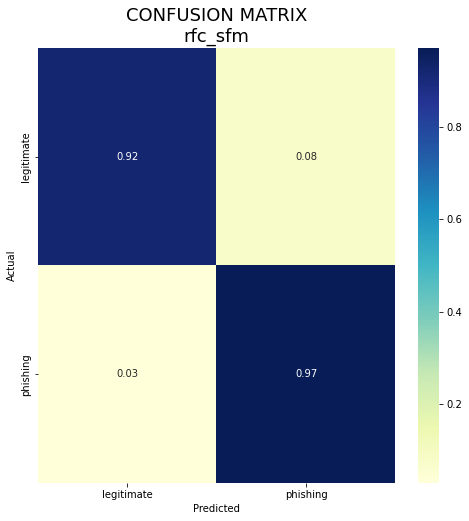

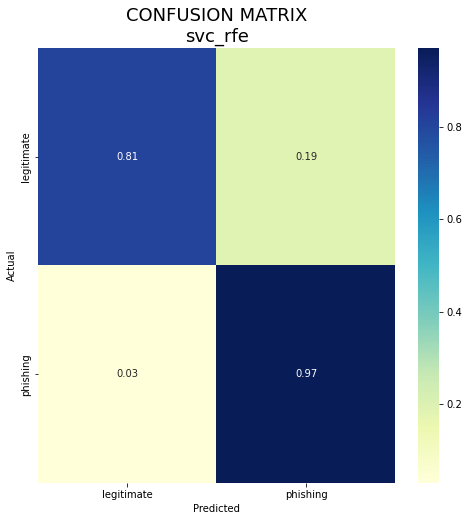

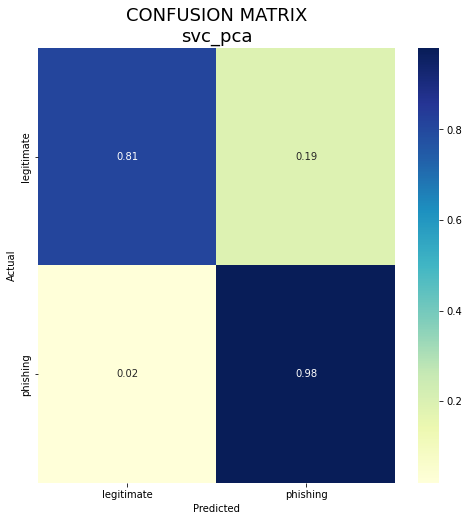

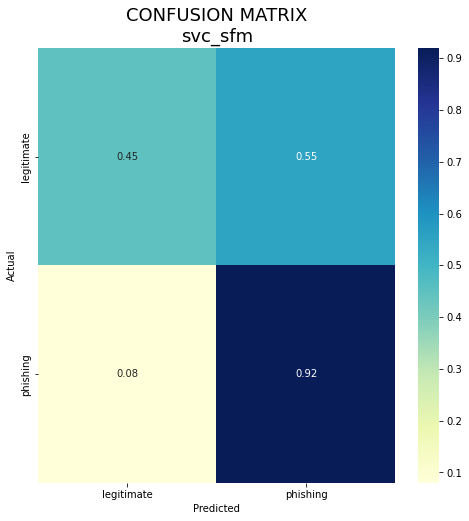

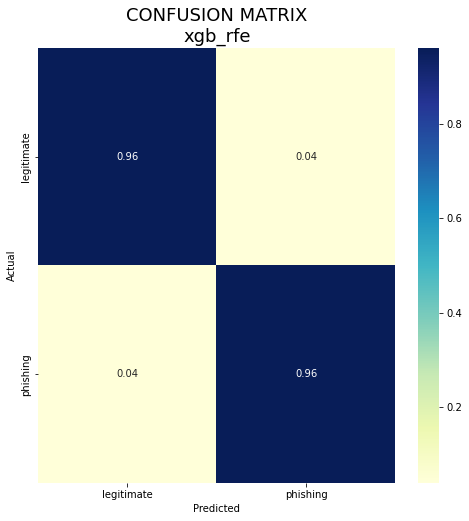

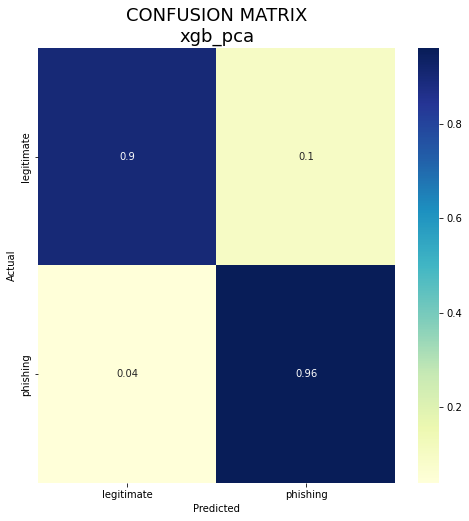

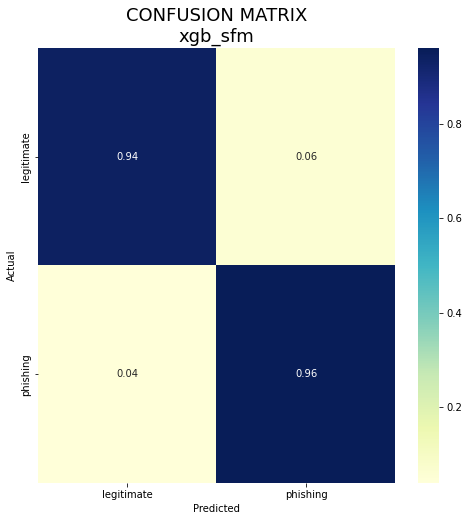

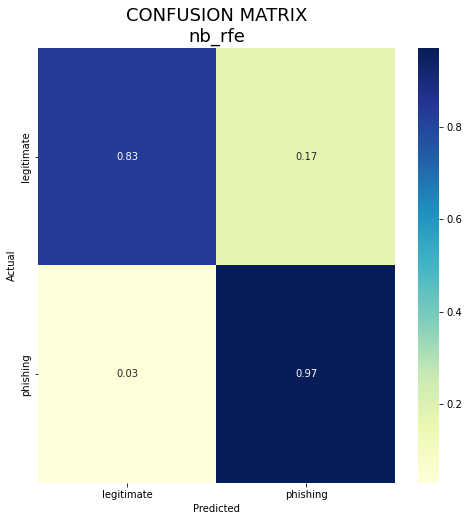

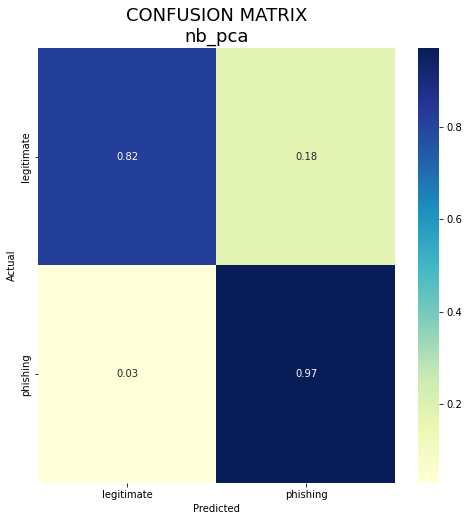

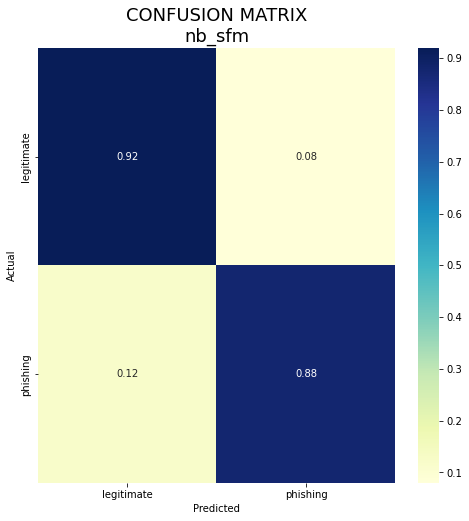

In [ ]:
#Printing confusion matrices for each model
for key in model_dict:
  get_accuracy(x_test,y_test,model_dict[key],key,True)

In [ ]:
#Printing classification reports
for x in model_dict:
  print('\nClassification Report: ' + str(x) + '\n',classification_report(y_test,model_dict[x].predict(x_test)))


Classification Report: rfc_rfe
               precision    recall  f1-score   support

           0       0.98      0.90      0.94     17449
           1       0.83      0.97      0.90      9146

    accuracy                           0.92     26595
   macro avg       0.91      0.93      0.92     26595
weighted avg       0.93      0.92      0.92     26595


Classification Report: rfc_pca
               precision    recall  f1-score   support

           0       0.98      0.89      0.93     17449
           1       0.82      0.97      0.89      9146

    accuracy                           0.92     26595
   macro avg       0.90      0.93      0.91     26595
weighted avg       0.93      0.92      0.92     26595


Classification Report: rfc_sfm
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     17449
           1       0.86      0.97      0.91      9146

    accuracy                           0.93     26595
   macro avg       0.92      

In [ ]:
#Printing F1-scores for each model
for model_key in model_dict:
  f1 = round(f1_score(y_test,model_dict[model_key].predict(x_test), average="weighted"),2)
  print(model_key,f1)

rfc_rfe 0.92
rfc_pca 0.92
rfc_sfm 0.93
svc_rfe 0.87
svc_pca 0.87
svc_sfm 0.61
xgb_rfe 0.96
xgb_pca 0.92
xgb_sfm 0.95
nb_rfe 0.88
nb_pca 0.88
nb_sfm 0.91


In [ ]:
df_results['mean_score'] = df_results['mean_score'].round(2)
df_results

,model,mean_score,Dim_reduction
0,rfc,0.94,rfe
1,rfc,0.93,pca
2,rfc,0.95,sfm
3,svc,0.84,rfe
4,svc,0.84,pca
5,svc,0.80,sfm
6,xgb,0.96,rfe
7,xgb,0.93,pca
8,xgb,0.96,sfm
9,nb,0.90,rfe


## Feature importance

<Figure size 2700x1800 with 0 Axes>

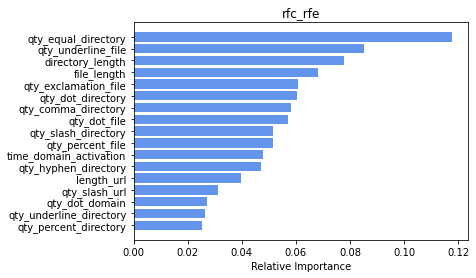

<Figure size 2700x1800 with 0 Axes>

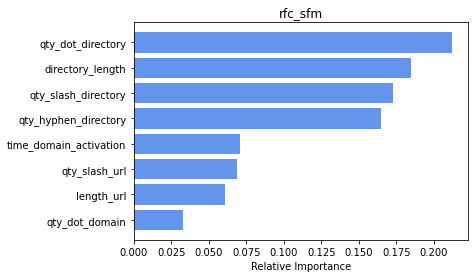

<Figure size 2700x1800 with 0 Axes>

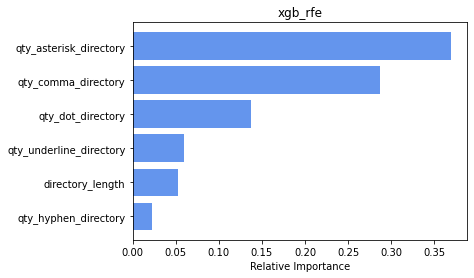

<Figure size 2700x1800 with 0 Axes>

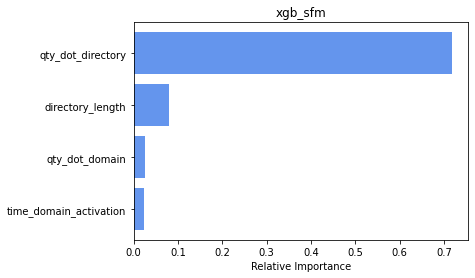

In [ ]:
def feature_visualization(df_final_features, key):
  ''' Create a visalisation with top informative features. As input takes dataframe and a key consisting name of a classifier and data engineering technique with an underscore'''
  figure(figsize=(9, 6), dpi=300)
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.barh(df_final_features['Feature'], df_final_features['Importance'], color='cornflowerblue', align='center')
  plt.xlabel('Relative Importance')
  plt.title(key)
  return plt.show()

for key in model_dict:
  # extract the needed model
  model_for_viz = model_dict[key]
  columns = ['Feature']
  # make a dataframe
  df_final_features = pd.DataFrame(columns=columns)
  feature_names = np.array(x_train_adasyn.columns.values)
  if key[:3]=="rfc" or key[:3]=="xgb":
    # extract features
    if key[-3:]!="pca":
      importance_features = model_for_viz.best_estimator_.named_steps["classifier"].feature_importances_
      if key[-3:]=="sfm":
        df_final_features = pd.DataFrame(feature_names[model_for_viz.best_estimator_.named_steps["feature"].get_support()], columns=columns)
      elif key[-3:]=="rfe":
        df_final_features = pd.DataFrame(feature_names[model_for_viz.best_estimator_.named_steps["feature"].support_], columns=columns)
      df_final_features['Importance'] = importance_features
      # keep features that contribute more than 2%
      df_threshold = df_final_features[df_final_features['Importance']>0.02]
      df_sorted = df_threshold.sort_values(by=['Importance'],ascending=True)
      feature_visualization(df_sorted, key)